In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchsummary 
from torch.utils.data import Dataset, DataLoader
import time
import neptune.new as neptune
from sklearn import pipeline, metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, train_test_split

In [2]:
torch.cuda.is_available()



True

In [3]:
number_to_activity ={ 
        '0': 'other'
        ,'1': 'lying'
        ,'2': 'sitting'
        ,'3': 'standing'
        ,'4': 'walking'
        ,'5': 'running'
        ,'6': 'cycling'
        ,'7': 'Nordic walking'
        ,'9': 'watching TV'
        ,'10':'computer work'
        ,'11':'car driving'
        ,'12':'ascending stairs'
        ,'13':'descending stairs'
        ,'16':'vacuum cleaning'
        ,'17':'ironing'
        ,'18':'folding laundry'
        ,'19':'house cleaning'
        ,'20':'playing soccer'
        ,'24':'rope jumping'
        }
activity_to_number ={ 
         'other':'0' 
        ,'lying':'1' 
        ,'sitting':'2' 
        ,'standing':'3' 
        ,'walking':'4' 
        ,'running':'5' 
        ,'cycling':'6' 
        ,'Nordic walking':'7' 
        ,'watching TV':'9' 
        ,'computer work':'10'
        ,'car driving':'11' 
        ,'ascending stairs':'12' 
        ,'descending stairs':'13' 
        ,'vacuum cleaning':'16' 
        ,'ironing':'17' 
        ,'folding laundry':'18' 
        ,'house cleaning':'19' 
        ,'playing soccer':'20' 
        ,'rope jumping':'24' 
        }

In [37]:
def sliding_window(df, window_size, stride):
    data = df.copy()
    data = data.reset_index(drop=True)
    data = data.to_numpy()
    data_list = []
    for i in range(0, len(data), stride):
        if i + window_size < len(data):
            data_list.append(data[i:i+window_size])
        else:
            return torch.Tensor(data_list)

#Function to interpolate NaNs because we want to keep the data continuous
def interpolate_nans(df):
    df = df.interpolate(method='linear', axis=0).ffill().bfill()
    return df

def calc_trend(df,feature):
    if df[-1,feature] > df[0,feature]:
        return 1
    else:
        return 0

def pool_data(pretraining_df,subjects,activities,ws):
    data = {}
    for activity in activities:
        data[activity] = torch.empty(0,ws,33)
        for subject in subjects:
            if pretraining_df[(subject,activity)] is not None :
                data[activity] = torch.cat((data[activity],pretraining_df[(subject,activity)]),0)
    return data

def create_labels_for_pretraining(data,activities,feature_for_trend):
    y_pooled= []
    x_pooled = [] 
    for act in activities:
        for sequence in data[act]:
            x_pooled.append(sequence[:,3:])   # drop time stamp and activity ID 
            y_pooled.append(calc_trend(sequence,feature_for_trend))
    return x_pooled , y_pooled

def get_labels(data,activities):
    y = []
    x = [] 
    for act in activities:
        for sequence in data[act]:
            x.append(sequence[:,2:])   # drop time stamp and activity ID 
            if int(act) == 24:
                y.append(21)
            else:
                y.append(int(act))
    return x , y

def train_loop(data_loader, model,device,loss_fn,optimizer,print_every_n=200):
    model.train()
    size = len(data_loader.dataset)
    num_batches = len(data_loader)
    train_loss=0
    tp=0
    for batch,(X,y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(dtype=torch.long)
        y = y.to(device)
        pred = model(X)
        loss = loss_fn(pred,y)
        train_loss += loss
        tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss, current = loss.item(), batch*len(X)
        if batch%print_every_n==0:
            print(f'loss={loss:.3f}, {current} / {size}')

    train_loss /= num_batches
    train_acc = tp/size    
        
    return train_loss,train_acc

def validation_loop(data_loader,model,device,loss_fn):
    model.eval()
    size=len(data_loader.dataset)
    num_batches = len(data_loader)
    val_loss=0
    tp=0
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(dtype=torch.long)
            y = y.to(device)
            pred = model(X)
            val_loss += loss_fn(pred,y).item()
            tp += (y==pred.argmax(1)).type(torch.float).sum().item()
        
    val_loss /= num_batches
    val_acc = tp/size
    print(f'accuracy = {val_acc}, val_loss = {val_loss:2f}')
    return val_loss,val_acc

In [5]:
full_df= pd.read_pickle('subjects_data_new.pickle')

subject_data = {}

keys = full_df.keys()
# keys = [key for key in keys if key not in [107,108]]
list_of_classes = list(number_to_activity.keys())

window_size = 400
num_features = 33
stride = 100

for key in keys:
    print(f"Now reading subject number {key}")
    df = full_df[key].copy()
    for label in list_of_classes:
        # Should perform different sliding windows here per subject
        new_data = df[df['activityID'] == int(label)]
        # Interpolate NaNs per subject per activity ( No mixup of data)
        new_data = interpolate_nans(new_data)
        # Sliding window per subject per activity
        subject_data[key,label] = sliding_window(new_data, window_size, stride)

pd.to_pickle(subject_data,"C:\\Users\\nati\\Desktop\\New folder\\data.pickle")

Now reading subject number 101


C:\Users\nati\AppData\Local\Temp\ipykernel_23984\337613071.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:233.)
  return torch.Tensor(data_list)


Now reading subject number 102
Now reading subject number 103
Now reading subject number 104
Now reading subject number 105
Now reading subject number 106
Now reading subject number 107
Now reading subject number 108
Now reading subject number 109


In [ ]:
pretraining_df = pd.read_pickle("C:\\Users\\nati\\Desktop\\New folder\\data_ws_800.pickle")
#Pool the data together for each activity
activities = ["0","1","2","3","4","5","6","7","9","10","11","12","13","16","17","18","19","20","24"]

subjects = [101,102,103,104,105,106,109]
subjects_test = [107,108]

x_train = pool_data(pretraining_df,subjects,activities,400)
x_test = pool_data(pretraining_df,subjects_test,activities,400)

In [6]:
pretraining_df = pd.read_pickle("C:\\Users\\nati\\Desktop\\New folder\\data.pickle")

In [153]:
#Create labels for pretraining
feature_for_trend = 2 # 2 is the x axis
x_train_pooled,y_train_pooled= create_labels_for_pretraining(x_train,activities,feature_for_trend)
x_test_pooled,y_test_pooled = create_labels_for_pretraining(x_test,activities,feature_for_trend)
x_train_pooled = torch.stack(x_train_pooled)
x_test_pooled = torch.stack(x_test_pooled)
y_train_pooled = torch.Tensor(y_train_pooled)
y_test_pooled = torch.Tensor(y_test_pooled)
y_test_pooled.unique(return_counts=True)

(tensor([0., 1.]), tensor([4281, 2847]))

In [8]:
#Fine tuning task
x_train_finetuning , y_train_finetuning = get_labels(x_train,activities)
x_test_finetuning , y_test_finetuning = get_labels(x_test,activities)
x_train_finetuning = torch.stack(x_train_finetuning)
x_test_finetuning = torch.stack(x_test_finetuning)
y_train_finetuning = torch.Tensor(y_train_finetuning)
y_test_finetuning = torch.Tensor(y_test_finetuning)
y_test_finetuning.unique(return_counts=True)

(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., 12., 13., 16., 17., 21.]),
 tensor([2261,  491,  345,  502,  646,  195,  474,  569,  286,  206,  451,  617,
           85]))

In [9]:
class activity_dataset(Dataset):    
    def __init__(self, X, y, transform=None, trarget_transform=None):
        self.X = X 
        self.y = y
        self.transform = transform
        self.target_transform = trarget_transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self,idx):
        X = self.X[idx]
        y = self.y[idx]
        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            y = self.target_transform(y)
        return X, y

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Computation resource: {device}')

Computation resource: cuda


In [11]:
class LSTM_Classifier(nn.Module):
    def __init__(self, input_dim=31, hidden_dim=256, num_layers=2, output_dim=22, dropout=0):
        '''
        input_dim = number of features at each time step 
        hidden_dim = number of features produced by each LSTM cell (in each layer)
        num_layers = number of LSTM layers
        output_dim = number of classes (number of activities)
        '''
        super().__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, 
                            num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
        
    def forward(self, X):
        hidden_features, (h_n, c_n) = self.lstm(X)  # (h_0, c_0) default to zeros
        hidden_features = hidden_features[:,-1,:]  # index only the features produced by the last LSTM cell
        out = self.fc(hidden_features)
        return out

# Pretraining the Network

In [154]:
x_train_pooled,x_val_pooled,y_train_pooled,y_val_pooled = train_test_split(x_train_pooled,y_train_pooled,test_size=0.2,shuffle=True)


In [159]:
#Pretraining Configurations
batch_size=64
train_loader = DataLoader(activity_dataset(x_train_pooled,y_train_pooled), shuffle=False, batch_size=batch_size)
validation_loader = DataLoader(activity_dataset(x_val_pooled,y_val_pooled), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(activity_dataset(x_test_pooled,y_test_pooled), shuffle=False, batch_size=batch_size)
lr = 0.001
best_acc = 0
model = LSTM_Classifier(dropout=0.75,num_layers=5,input_dim=30)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

In [ ]:
run = neptune.init(
    project="astarteam/PDLW-assignment-2",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials
run["algorithm"] = "LSTM-Pretraining-2ndTrial"

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "optimizer": "CrossEntropyLoss"}

run["parameters"] = params

results = []
# define the number of epochs and early stopping patience
epochs = 50
patience = 5
best_loss = np.inf
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_loop(train_loader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60
    val_loss, val_acc = validation_loop(validation_loader, model, device, criterion)
    run["train/accuracy"].log(train_acc)
    run["train/loss"].log(train_loss)
    run['train/run_time'].log(total_train_time)
    run["validation/accuracy"].log(val_acc)
    run["validation/loss"].log(val_loss)
    results.append({'epoch_number':epoch,'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss,'train_acc':train_acc,'val_acc':val_acc, 'train_time':total_train_time})
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
    if val_loss < best_loss:
        torch.save(model.state_dict(), f'pretraining_{epoch}.pth')
        val_loss,val_acc = validation_loop(validation_loader, model, device, criterion)
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break
run.stop()

import time
pd.to_pickle(results,f"C:\\Users\\nati\\Desktop\\New folder\\Results_LSTM_Pretraining_{time.time()}.pickle")

## Finetuning the pretrained network


In [12]:
weight_prob_dict = { 
        '0': 0.012
        ,'1': 0.059
        ,'2': 0.055
        ,'3': 0.06 
        ,'4': 0.048
        ,'5': 0.107
        ,'6': 0.072
        ,'7': 0.063
        ,'12': 0.097
        ,'13':0.102
        ,'16':0.064
        ,'17':0.047
        ,'21':0.215 }

In [13]:
x_train_finetuning,x_val_finetuning,y_train_finetuning,y_val_finetuning = train_test_split(x_train_finetuning,y_train_finetuning,test_size=0.2,shuffle=True)


In [14]:
x_train_finetuning.shape

torch.Size([16996, 400, 31])

In [15]:
#Creating Weights to deal with imbalanced dataset
total = y_train_finetuning.unique(return_counts=True)[1].sum().item()
probas = [x.item()/total for x in  y_train_finetuning.unique(return_counts=True)[1]]
probas = np.round(probas,3)
weights = 1/probas
weights = np.round(weights/sum(weights),3)
final_weights = []
for sample in y_train_finetuning:
    final_weights.append(weight_prob_dict[str(int(sample.item()))])

In [16]:
len(final_weights)

16996

In [17]:
from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(final_weights, len(final_weights))


In [18]:
batch_size=64
train_loader = DataLoader(activity_dataset(x_train_finetuning,y_train_finetuning), shuffle=False, batch_size=batch_size,sampler=sampler)
validation_loader = DataLoader(activity_dataset(x_val_finetuning,y_val_finetuning), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(activity_dataset(x_test_finetuning,y_test_finetuning), shuffle=False, batch_size=batch_size)
lr = 0.001
best_acc = 0
model = LSTM_Classifier(dropout=0.75,num_layers=5)
model.load_state_dict(torch.load("model_pretraining_weighted_23.pth"))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

In [163]:
model.load_state_dict(torch.load("model_pretraining_weighted_23.pth"))


<All keys matched successfully>

In [164]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True

In [19]:
print(x_train_finetuning.shape,x_val_finetuning.shape,y_train_finetuning.shape,y_val_finetuning.shape)

torch.Size([16996, 400, 31]) torch.Size([4250, 400, 31]) torch.Size([16996]) torch.Size([4250])


In [20]:
run = neptune.init(
    project="astarteam/PDLW-assignment-2",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials
run["algorithm"] = "LSTM-Finetuning-WeightedSamples"

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "optimizer": "CrossEntropyLoss"}

run["parameters"] = params

results = []
# define the number of epochs and early stopping patience
epochs = 50
patience = 5
best_loss = np.inf
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_loop(train_loader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60
    val_loss, val_acc = validation_loop(validation_loader, model, device, criterion)
    run["train/accuracy"].log(train_acc)
    run["train/loss"].log(train_loss)
    run['train/run_time'].log(total_train_time)
    run["validation/accuracy"].log(val_acc)
    run["validation/loss"].log(val_loss)
    results.append({'epoch_number':epoch,'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss,'train_acc':train_acc,'val_acc':val_acc, 'train_time':total_train_time})
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
    if val_loss < best_loss:
        torch.save(model.state_dict(), f'model_pretraining_weighted_{epoch}.pth')
        val_loss,val_acc = validation_loop(validation_loader, model, device, criterion)
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break
run.stop()

import time
pd.to_pickle(results,f"C:\\Users\\nati\\Desktop\\New folder\\Results_LSTM_Finetuned{time.time()}.pickle")


C:\Users\nati\AppData\Local\Temp\ipykernel_23984\3509020738.py:1: NeptuneDeprecationWarning: `init` is deprecated, use `init_run` instead. We'll end support of it in `neptune-client==1.0.0`.
  run = neptune.init(


https://app.neptune.ai/astarteam/PDLW-assignment-2/e/PDLWAS-58
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
loss=0.283, 0 / 16996
loss=0.284, 12800 / 16996
accuracy = 0.7287058823529412, val_loss = 0.899635
accuracy = 0.7287058823529412, val_loss = 0.899635
loss=0.188, 0 / 16996
loss=0.422, 12800 / 16996
accuracy = 0.7051764705882353, val_loss = 1.005842
loss=0.371, 0 / 16996
loss=0.251, 12800 / 16996
accuracy = 0.7287058823529412, val_loss = 0.901895
loss=0.260, 0 / 16996
loss=0.175, 12800 / 16996
accuracy = 0.7661176470588236, val_loss = 0.811919
accuracy = 0.7661176470588236, val_loss = 0.811919
loss=0.506, 0 / 16996
loss=0.400, 12800 / 16996
accuracy = 0.6955294117647058, val_loss = 0.997757
loss=0.242, 0 / 16996
loss=0.327, 12800 / 16996
accuracy = 0.7632941176470588, val_loss = 0.760023
accuracy = 0.7632941176470588, val

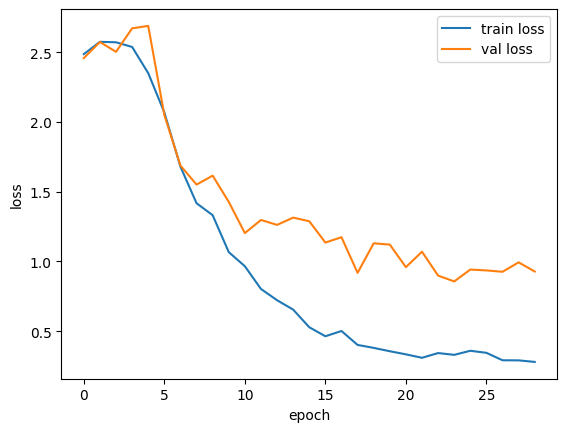

In [140]:
df = pd.DataFrame(results)
plt.plot(df.index ,df.train_loss, label = "train loss")
plt.plot(df.index , df.val_loss, label = "val loss")
plt.title = 'Learning curve'
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

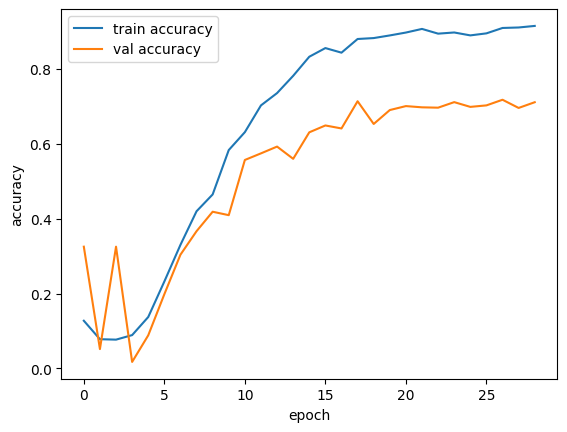

In [142]:
plt.plot(df.index ,df.train_acc, label = "train accuracy")
plt.plot(df.index , df.val_acc, label = "val accuracy")
plt.title = 'Learning curve'
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [114]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!
Waiting for the remaining 18 operations to synchronize with Neptune. Do not kill this process.
All 18 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astarteam/PDLW-assignment-2/e/PDLWAS-53


In [21]:
val_loss, val_acc = validation_loop(test_loader, model, device, criterion)

accuracy = 0.47152076318742986, val_loss = 2.303519


In [22]:
def sampling_test(data_loader,model,device):
    model.eval()
    preds = []
    gt = []
    with torch.no_grad():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(dtype=torch.long)
            y = y.to(device)
            pred = model(X)
            preds.append(pred.argmax(1).detach().cpu().numpy())
            gt.append(y.detach().cpu().numpy())
            
    return preds,gt

In [23]:
sample_loader = DataLoader(activity_dataset(x_test_finetuning,y_test_finetuning), shuffle=False, batch_size=batch_size)


In [24]:
preds,gt = sampling_test(sample_loader,model,device)

In [25]:
weights

array([0.012, 0.058, 0.057, 0.06 , 0.049, 0.106, 0.072, 0.063, 0.1  ,
       0.103, 0.065, 0.048, 0.206])

In [80]:
y_train_finetuning.unique(return_counts=True)[0]

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., 12., 13., 16., 17., 21.])

In [92]:
final_weights = np.array(final_weights)

In [29]:

preds = np.concatenate(preds)
gt = np.concatenate(gt)

In [30]:
preds

array([ 3,  3,  3, ..., 21, 21, 21], dtype=int64)

In [32]:

from sklearn.metrics import accuracy_score,confusion_matrix
display(accuracy_score(gt,preds))
display(confusion_matrix(gt,preds))

0.47152076318742986

array([[790,  16, 143, 289, 181, 100,  49,   6,  45, 132, 456,  14,  40],
       [  4, 257, 224,   0,   0,   0,   0,   0,   0,   0,   6,   0,   0],
       [  0,   0, 259,  79,   0,   0,   0,   0,   0,   0,   7,   0,   0],
       [ 45,   0,   0, 346,   0,   0,   0,   0,   0,   0, 111,   0,   0],
       [260,   1,   3,  32, 347,   0,   0,   0,   3,   0,   0,   0,   0],
       [ 10,   0,   0,   0,   9,  30,   0,   0,   0, 143,   0,   0,   3],
       [ 48,   0,   0,   0,  15,   0, 313,   0,   2,   4,  74,  18,   0],
       [259,   0,   2,  12,  10,  70,   1, 204,   1,   3,   6,   0,   1],
       [ 78,   0,   1,   5,  11,   1,   0,   0, 134,   2,  39,   0,  15],
       [ 56,   0,   0,   5,  26,   0,   0,   0,   6, 103,  10,   0,   0],
       [ 43,   1,  35,  29,   1,   0,  33,   0,   0,   0, 281,  28,   0],
       [ 78,   0,  60,  98,   0,   0,  37,   0,   0,   0,  53, 291,   0],
       [  7,   0,   0,   0,   0,   1,   0,   0,   1,  70,   0,   0,   6]],
      dtype=int64)

## Using our pre-training task we realized we er're getting even worse results than without pretraining
## Therefore we figured the original feature we created as target has too much of a difference from our original task target distribution.
## We then tried to learn with the trend of the heartrate within a 4-sec time window as our target.
## That didn't work out too well as well.


## 3 Ideas to improve our results:
## 1) We can create a more complicated task for pretraining which resembles the original task a bit better.
## 2) We can try to get rid of class - 0 because it is all the transient activities which may look like another class in terms of the data but is labeled
## as 0 and therefor creates alot of noise for our algorithm
## 3) We can try a different model for our task.

In [33]:
full_df= pd.read_pickle('subjects_data_new.pickle')

subject_data = {}

keys = full_df.keys()
# keys = [key for key in keys if key not in [107,108]]
list_of_classes = list(number_to_activity.keys())

window_size = 800
num_features = 33
stride = 100

for key in keys:
    print(f"Now reading subject number {key}")
    df = full_df[key].copy()
    for label in list_of_classes:
        # Should perform different sliding windows here per subject
        new_data = df[df['activityID'] == int(label)]
        # Interpolate NaNs per subject per activity ( No mixup of data)
        new_data = interpolate_nans(new_data)
        # Sliding window per subject per activity
        subject_data[key,label] = sliding_window(new_data, window_size, stride)

pd.to_pickle(subject_data,"C:\\Users\\nati\\Desktop\\New folder\\data_ws_800.pickle")

Now reading subject number 101
Now reading subject number 102
Now reading subject number 103
Now reading subject number 104
Now reading subject number 105
Now reading subject number 106
Now reading subject number 107
Now reading subject number 108
Now reading subject number 109


In [35]:
pretraining_df = pd.read_pickle("C:\\Users\\nati\\Desktop\\New folder\\data_ws_800.pickle")

In [38]:
#Pool the data together for each activity
activities = ["0","1","2","3","4","5","6","7","9","10","11","12","13","16","17","18","19","20","24"]

subjects = [101,102,103,104,105,106,109]
subjects_test = [107,108]

x_train = pool_data(pretraining_df,subjects,activities,800)
x_test = pool_data(pretraining_df,subjects_test,activities,800)

#Fine tuning task
x_train_finetuning , y_train_finetuning = get_labels(x_train,activities)
x_test_finetuning , y_test_finetuning = get_labels(x_test,activities)
x_train_finetuning = torch.stack(x_train_finetuning)
x_test_finetuning = torch.stack(x_test_finetuning)
y_train_finetuning = torch.Tensor(y_train_finetuning)
y_test_finetuning = torch.Tensor(y_test_finetuning)
y_test_finetuning.unique(return_counts=True)



(tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7., 12., 13., 16., 17., 21.]),
 tensor([2253,  483,  337,  494,  638,  187,  466,  561,  278,  198,  443,  609,
           81]))

In [39]:
weight_prob_dict = { 
        '0': 0.012
        ,'1': 0.059
        ,'2': 0.055
        ,'3': 0.06 
        ,'4': 0.048
        ,'5': 0.107
        ,'6': 0.072
        ,'7': 0.063
        ,'12': 0.097
        ,'13':0.102
        ,'16':0.064
        ,'17':0.047
        ,'21':0.215 }

x_train_finetuning,x_val_finetuning,y_train_finetuning,y_val_finetuning = train_test_split(x_train_finetuning,y_train_finetuning,test_size=0.2,shuffle=True)
#Creating Weights to deal with imbalanced dataset
total = y_train_finetuning.unique(return_counts=True)[1].sum().item()
probas = [x.item()/total for x in  y_train_finetuning.unique(return_counts=True)[1]]
probas = np.round(probas,3)
weights = 1/probas
weights = np.round(weights/sum(weights),3)
final_weights = []
for sample in y_train_finetuning:
    final_weights.append(weight_prob_dict[str(int(sample.item()))])


from torch.utils.data import WeightedRandomSampler
sampler = WeightedRandomSampler(final_weights, len(final_weights))


batch_size=64
train_loader = DataLoader(activity_dataset(x_train_finetuning,y_train_finetuning), shuffle=False, batch_size=batch_size,sampler=sampler)
validation_loader = DataLoader(activity_dataset(x_val_finetuning,y_val_finetuning), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(activity_dataset(x_test_finetuning,y_test_finetuning), shuffle=False, batch_size=batch_size)
lr = 0.001
best_acc = 0
model = LSTM_Classifier(dropout=0.75,num_layers=5)
model.load_state_dict(torch.load("model_pretraining_weighted_23.pth"))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True


run = neptune.init(
    project="astarteam/PDLW-assignment-2",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials
run["algorithm"] = "LSTM-Finetuning-WeightedSamples"

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "optimizer": "CrossEntropyLoss"}

run["parameters"] = params

results = []
# define the number of epochs and early stopping patience
epochs = 50
patience = 5
best_loss = np.inf
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_loop(train_loader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60
    val_loss, val_acc = validation_loop(validation_loader, model, device, criterion)
    run["train/accuracy"].log(train_acc)
    run["train/loss"].log(train_loss)
    run['train/run_time'].log(total_train_time)
    run["validation/accuracy"].log(val_acc)
    run["validation/loss"].log(val_loss)
    results.append({'epoch_number':epoch,'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss,'train_acc':train_acc,'val_acc':val_acc, 'train_time':total_train_time})
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
    if val_loss < best_loss:
        torch.save(model.state_dict(), f'model_pretraining_weighted_{epoch}.pth')
        val_loss,val_acc = validation_loop(validation_loader, model, device, criterion)
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break
run.stop()

import time
pd.to_pickle(results,f"C:\\Users\\nati\\Desktop\\New folder\\Results_LSTM_Finetuned_2{time.time()}.pickle")



https://app.neptune.ai/astarteam/PDLW-assignment-2/e/PDLWAS-59
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
loss=0.248, 0 / 16763
loss=0.407, 12800 / 16763
accuracy = 0.798616082080649, val_loss = 0.572018
accuracy = 0.798616082080649, val_loss = 0.572018
loss=0.109, 0 / 16763
loss=0.252, 12800 / 16763
accuracy = 0.7131949415413983, val_loss = 0.800732
loss=0.182, 0 / 16763
loss=0.059, 12800 / 16763
accuracy = 0.7716535433070866, val_loss = 0.696120
loss=0.269, 0 / 16763
loss=0.168, 12800 / 16763
accuracy = 0.754712479121928, val_loss = 0.805550
loss=0.429, 0 / 16763
loss=0.151, 12800 / 16763
accuracy = 0.747792889525173, val_loss = 0.734532
loss=0.203, 0 / 16763
loss=0.115, 12800 / 16763
accuracy = 0.830112145072775, val_loss = 0.470985
accuracy = 0.830112145072775, val_loss = 0.470985
loss=0.127, 0 / 16763
loss=0.226, 12800 

In [40]:
sample_loader = DataLoader(activity_dataset(x_test_finetuning,y_test_finetuning), shuffle=False, batch_size=batch_size)
preds,gt = sampling_test(sample_loader,model,device)
preds = np.concatenate(preds)
gt = np.concatenate(gt)
from sklearn.metrics import accuracy_score,confusion_matrix
display(accuracy_score(gt,preds))
display(confusion_matrix(gt,preds))

0.5862265224815025

array([[1281,    0,   51,  584,   77,    2,   28,    0,   54,   91,   66,
          19,    0],
       [   1,  480,    2,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,    0,  111,  221,    0,    0,    0,    0,    0,    0,    5,
           0,    0],
       [   8,    0,    5,  480,    0,    0,    0,    0,    0,    0,    0,
           1,    0],
       [ 294,    0,    0,    3,  329,    0,    0,    0,   10,    2,    0,
           0,    0],
       [  38,    0,    0,    0,    4,   27,    0,    0,   25,   93,    0,
           0,    0],
       [  16,    0,    0,    0,    0,    0,  369,    0,    0,    0,   80,
           1,    0],
       [ 155,    0,    0,    1,    1,   64,    0,  209,    0,  130,    0,
           0,    1],
       [  76,    0,    0,    0,    0,    0,    0,    0,  165,    0,   37,
           0,    0],
       [  85,    0,    0,    1,    2,    0,    0,    0,    1,  109,    0,
           0,    0],
       [  37,    0,    9,   58,    0,    0,   30, 

In [61]:

batch_size=64
train_loader = DataLoader(activity_dataset(x_train_finetuning,y_train_finetuning), shuffle=False, batch_size=batch_size,sampler=sampler)
validation_loader = DataLoader(activity_dataset(x_val_finetuning,y_val_finetuning), shuffle=False, batch_size=batch_size)
test_loader = DataLoader(activity_dataset(x_test_finetuning,y_test_finetuning), shuffle=False, batch_size=batch_size)
lr = 0.001
best_acc = 0
model = LSTM_Classifier(dropout=0.75,num_layers=5,hidden_dim=512)
#model.load_state_dict(torch.load("model_pretraining_weighted_23.pth"))
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
save_each_epoch = True


run = neptune.init(
    project="astarteam/PDLW-assignment-2",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJhMDI5YzIxMy00NjE1LTQ2MDUtOTk3NS1jNDJhMjIzZDE0NDMifQ==",
)  # your credentials
run["algorithm"] = "LSTM-Finetuning-WeightedSamples"

params = {"batch_size": batch_size,
        "learning_rate": lr, 
        "optimizer": "CrossEntropyLoss"}

run["parameters"] = params

results = []
# define the number of epochs and early stopping patience
epochs = 50
patience = 5
best_loss = np.inf
for epoch in range(epochs):
    start_time = time.time()
    train_loss, train_acc = train_loop(train_loader, model, device, criterion, optimizer)
    total_train_time = (time.time() - start_time)/60
    val_loss, val_acc = validation_loop(validation_loader, model, device, criterion)
    run["train/accuracy"].log(train_acc)
    run["train/loss"].log(train_loss)
    run['train/run_time'].log(total_train_time)
    run["validation/accuracy"].log(val_acc)
    run["validation/loss"].log(val_loss)
    results.append({'epoch_number':epoch,'train_loss':train_loss.detach().cpu().numpy(),'val_loss':val_loss,'train_acc':train_acc,'val_acc':val_acc, 'train_time':total_train_time})
    # if the validation loss is the best seen so far, update the best loss and reset the early stopping counter
    if val_loss < best_loss:
        torch.save(model.state_dict(), f'model_pretraining_weighted__hidden_dim{epoch}.pth')
        val_loss,val_acc = validation_loop(validation_loader, model, device, criterion)
        best_loss = val_loss
        early_stopping_counter = 0
    # otherwise, increment the early stopping counter
    else:
        early_stopping_counter += 1     
    # if the early stopping counter has reached the patience, stop training
    if early_stopping_counter == patience:
        break
run.stop()

import time
pd.to_pickle(results,f"C:\\Users\\nati\\Desktop\\New folder\\Results_LSTM_Finetuned_2{time.time()}.pickle")



https://app.neptune.ai/astarteam/PDLW-assignment-2/e/PDLWAS-60
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.
loss=3.083, 0 / 16763
loss=1.974, 12800 / 16763
accuracy = 0.18611309949892627, val_loss = 2.045121
accuracy = 0.18611309949892627, val_loss = 2.045121
loss=2.080, 0 / 16763
loss=1.930, 12800 / 16763
accuracy = 0.2335958005249344, val_loss = 1.842878
accuracy = 0.2335958005249344, val_loss = 1.842878
loss=1.742, 0 / 16763
loss=1.206, 12800 / 16763
accuracy = 0.2915771892149845, val_loss = 1.628604
accuracy = 0.2915771892149845, val_loss = 1.628604
loss=1.490, 0 / 16763
loss=1.310, 12800 / 16763
accuracy = 0.34836554521593893, val_loss = 1.601846
accuracy = 0.34836554521593893, val_loss = 1.601846
loss=1.360, 0 / 16763
loss=1.134, 12800 / 16763
accuracy = 0.3445478406108327, val_loss = 1.474161
accuracy = 0.34454784061083